<a href="https://colab.research.google.com/github/lasya1125/COMP562FinalProject/blob/main/Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import string
import nltk
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from datetime import datetime
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from nltk.corpus import stopwords
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
df = pd.read_csv('movies.csv')
df.head()

,id,title,vote_average,overview,revenue,release_date
0,118365,"Moses, Prince of Egypt",5.5,"At birth, Moses, a Hebrew baby is abandoned on...",0,2000-01-01
1,10567,Dinosaur,6.5,An orphaned dinosaur raised by lemurs joins an...,354248063,2000-05-19
2,4247,Scary Movie,6.3,A familiar-looking group of teenagers find the...,278019771,2000-07-07
3,8871,How the Grinch Stole Christmas,6.7,Inside a snowflake exists the magical land of ...,345141403,2000-11-17
4,11688,The Emperor's New Groove,7.5,Kuzco is a self-centered emperor who summons P...,169327687,2000-12-15


In [3]:
df = df.drop(['id'], axis=1)
df.head()

,title,vote_average,overview,revenue,release_date
0,"Moses, Prince of Egypt",5.5,"At birth, Moses, a Hebrew baby is abandoned on...",0,2000-01-01
1,Dinosaur,6.5,An orphaned dinosaur raised by lemurs joins an...,354248063,2000-05-19
2,Scary Movie,6.3,A familiar-looking group of teenagers find the...,278019771,2000-07-07
3,How the Grinch Stole Christmas,6.7,Inside a snowflake exists the magical land of ...,345141403,2000-11-17
4,The Emperor's New Groove,7.5,Kuzco is a self-centered emperor who summons P...,169327687,2000-12-15


In [4]:
print(df.isnull().sum())
print(df.shape)

title           0
vote_average    0
overview        9
revenue         0
release_date    0
dtype: int64
(6000, 5)


In [5]:
df = df.dropna(axis=0)
print(df.isnull().sum())
print(df.shape)

title           0
vote_average    0
overview        0
revenue         0
release_date    0
dtype: int64
(5991, 5)


In [6]:
df = df.loc[df['revenue'] != 0]
df.shape

(3884, 5)

In [7]:
df.describe()

,vote_average,revenue
count,3884.000000,3.884000e+03
mean,6.421138,1.442320e+08
std,0.830765,2.196025e+08
min,2.700000,1.000000e+00
25%,5.900000,2.270706e+07
50%,6.400000,6.991741e+07
75%,7.000000,1.680251e+08
max,8.600000,2.797801e+09


In [8]:
cat = pd.cut(df['revenue'],bins=[0,2.5e7,7.5e7,1.75e8,5e8,1e9],labels=['1','2','3','4','5'])
df.insert(4,"revenue_cat",cat)
df.head()

,title,vote_average,overview,revenue,revenue_cat,release_date
1,Dinosaur,6.5,An orphaned dinosaur raised by lemurs joins an...,354248063,4,2000-05-19
2,Scary Movie,6.3,A familiar-looking group of teenagers find the...,278019771,4,2000-07-07
3,How the Grinch Stole Christmas,6.7,Inside a snowflake exists the magical land of ...,345141403,4,2000-11-17
4,The Emperor's New Groove,7.5,Kuzco is a self-centered emperor who summons P...,169327687,3,2000-12-15
5,The Road to El Dorado,7.2,"After a failed swindle, two con-men end up wit...",76432727,3,2000-03-31


In [9]:
df['title'] = df['title'].astype('category')
df['overview'] = df['overview'].astype('category')
df['revenue_cat'] = df['revenue_cat'].astype('category')
df['release_date']= pd.to_datetime(df['release_date'])

Text(0, 0.5, 'Count')

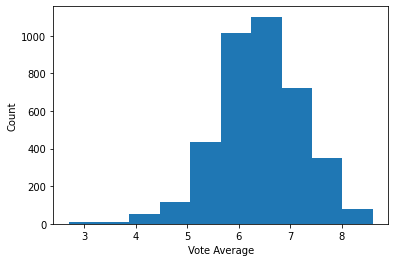

In [10]:
plt.hist(df['vote_average'])
plt.xlabel("Vote Average")
plt.ylabel("Count")

([<matplotlib.axis.XTick at 0x7f4542df6190>,
 <a list of 10 Text major ticklabel objects>)

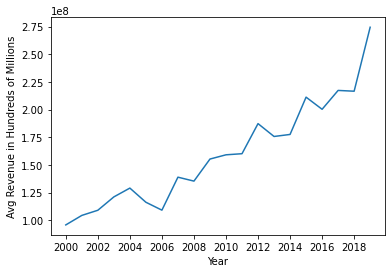

In [11]:
 series = df.groupby(df['release_date'].dt.year)['revenue'].agg('mean')
 plt.plot(series,)
 plt.xlabel("Year")
 plt.ylabel("Avg Revenue in Hundreds of Millions")
 plt.xticks(range(2000, 2019,2))

In [12]:
df['lower'] = [word.lower() for word in df['overview']]
df.head()

,title,vote_average,overview,revenue,revenue_cat,release_date,lower
1,Dinosaur,6.5,An orphaned dinosaur raised by lemurs joins an...,354248063,4,2000-05-19,an orphaned dinosaur raised by lemurs joins an...
2,Scary Movie,6.3,A familiar-looking group of teenagers find the...,278019771,4,2000-07-07,a familiar-looking group of teenagers find the...
3,How the Grinch Stole Christmas,6.7,Inside a snowflake exists the magical land of ...,345141403,4,2000-11-17,inside a snowflake exists the magical land of ...
4,The Emperor's New Groove,7.5,Kuzco is a self-centered emperor who summons P...,169327687,3,2000-12-15,kuzco is a self-centered emperor who summons p...
5,The Road to El Dorado,7.2,"After a failed swindle, two con-men end up wit...",76432727,3,2000-03-31,"after a failed swindle, two con-men end up wit..."


In [13]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df['lower'])
X_dense = X.todense()
X_dense.shape

(3884, 14307)

In [14]:
df_resp = df[['revenue_cat']]
df_pred = pd.DataFrame(X_dense)
df_resp.reset_index(drop=True, inplace = True)
df_pred.reset_index(drop=True, inplace = True)

In [15]:
print(df_resp.isnull().sum())

revenue_cat    45
dtype: int64


In [16]:
rows_with_nan = [index for index, row in df_resp.iterrows() if row.isnull().any()]

In [17]:
df_pred.drop(df_pred.index[rows_with_nan], inplace = True)
df_pred.reset_index(drop=True, inplace = True)

In [18]:
df_resp.dropna(inplace = True)
df_resp.reset_index(drop=True, inplace = True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [19]:
print(df_resp.shape)
print(df_pred.shape)

(3839, 1)
(3839, 14307)


In [20]:
df_ys = df_resp.squeeze(axis = 1)
df_ys.shape

(3839,)

In [21]:
model_1 = RandomForestClassifier(n_jobs = -1, random_state = 42, oob_score = True)
kf = KFold(n_splits=5, shuffle = True)
preds = []
tests = []
for train_index, test_index in kf.split(df_pred):
  X_train, X_test = df_pred.iloc[train_index,:], df_pred.iloc[test_index,:]
  y_train, y_test = df_ys.T[train_index], df_ys.T[test_index]
  model_1.fit(X_train, y_train)
  pred = model_1.predict(X_test)
  preds.append(pred)
  tests.append(y_test)

0.6888020833333334


Text(0.5, 15.0, 'Predicted')

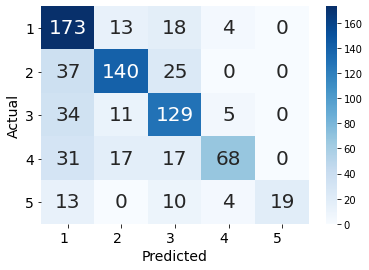

In [22]:
##1
print(accuracy_score(tests[0], preds[0]))
confusion = confusion_matrix(tests[0], preds[0])
confusion_matrix_df = pd.DataFrame(confusion, ('1', '2', '3', '4', '5'), ('1', '2', '3', '4', '5'))
heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={"size": 20}, fmt="d", cmap="Blues")
bottom, top = heatmap.get_ylim()
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize = 14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize = 14)
plt.ylabel('Actual', fontsize = 14)
plt.xlabel('Predicted', fontsize = 14)

0.6953125


Text(0.5, 15.0, 'Predicted')

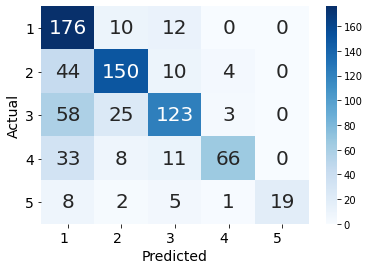

In [23]:
##2
print(accuracy_score(tests[1], preds[1]))
confusion = confusion_matrix(tests[1], preds[1])
confusion_matrix_df = pd.DataFrame(confusion, ('1', '2', '3', '4', '5'), ('1', '2', '3', '4', '5'))
heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={"size": 20}, fmt="d", cmap="Blues")
bottom, top = heatmap.get_ylim()
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize = 14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize = 14)
plt.ylabel('Actual', fontsize = 14)
plt.xlabel('Predicted', fontsize = 14)

0.6705729166666666


Text(0.5, 15.0, 'Predicted')

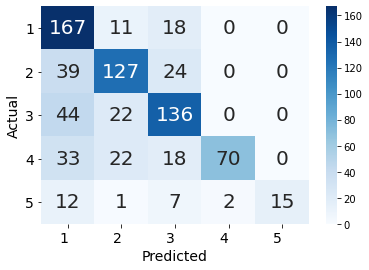

In [24]:
##3
print(accuracy_score(tests[2], preds[2]))
confusion = confusion_matrix(tests[2], preds[2])
confusion_matrix_df = pd.DataFrame(confusion, ('1', '2', '3', '4', '5'), ('1', '2', '3', '4', '5'))
heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={"size": 20}, fmt="d", cmap="Blues")
bottom, top = heatmap.get_ylim()
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize = 14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize = 14)
plt.ylabel('Actual', fontsize = 14)
plt.xlabel('Predicted', fontsize = 14)

0.6796875


Text(0.5, 15.0, 'Predicted')

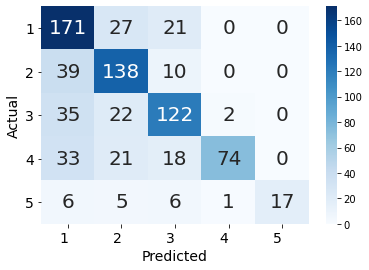

In [25]:
##4
print(accuracy_score(tests[3], preds[3]))
confusion = confusion_matrix(tests[3], preds[3])
confusion_matrix_df = pd.DataFrame(confusion, ('1', '2', '3', '4', '5'), ('1', '2', '3', '4', '5'))
heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={"size": 20}, fmt="d", cmap="Blues")
bottom, top = heatmap.get_ylim()
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize = 14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize = 14)
plt.ylabel('Actual', fontsize = 14)
plt.xlabel('Predicted', fontsize = 14)

0.6727509778357236


Text(0.5, 15.0, 'Predicted')

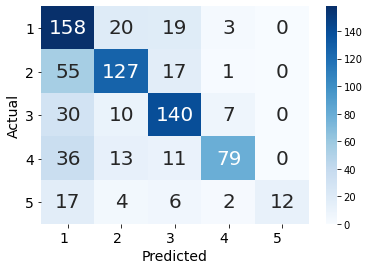

In [26]:
##5
print(accuracy_score(tests[4], preds[4]))
confusion = confusion_matrix(tests[4], preds[4])
confusion_matrix_df = pd.DataFrame(confusion, ('1', '2', '3', '4', '5'), ('1', '2', '3', '4', '5'))
heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={"size": 20}, fmt="d", cmap="Blues")
bottom, top = heatmap.get_ylim()
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize = 14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize = 14)
plt.ylabel('Actual', fontsize = 14)
plt.xlabel('Predicted', fontsize = 14)

In [27]:
df2 = df.copy()

In [28]:
nltk.download('stopwords')
stop = stopwords.words('english')
df2['text_wo_stop'] = df2['overview'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
df2['text_wo_stop_punc'] = df2['text_wo_stop'].apply(lambda x:''.join([i for i in x if i not in string.punctuation]))
df2.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,title,vote_average,overview,revenue,revenue_cat,release_date,lower,text_wo_stop,text_wo_stop_punc
1,Dinosaur,6.5,An orphaned dinosaur raised by lemurs joins an...,354248063,4,2000-05-19,an orphaned dinosaur raised by lemurs joins an...,An orphaned dinosaur raised lemurs joins arduo...,An orphaned dinosaur raised lemurs joins arduo...
2,Scary Movie,6.3,A familiar-looking group of teenagers find the...,278019771,4,2000-07-07,a familiar-looking group of teenagers find the...,A familiar-looking group teenagers find stalke...,A familiarlooking group teenagers find stalked...
3,How the Grinch Stole Christmas,6.7,Inside a snowflake exists the magical land of ...,345141403,4,2000-11-17,inside a snowflake exists the magical land of ...,Inside snowflake exists magical land Whoville....,Inside snowflake exists magical land Whoville ...
4,The Emperor's New Groove,7.5,Kuzco is a self-centered emperor who summons P...,169327687,3,2000-12-15,kuzco is a self-centered emperor who summons p...,Kuzco self-centered emperor summons Pacha vill...,Kuzco selfcentered emperor summons Pacha villa...
5,The Road to El Dorado,7.2,"After a failed swindle, two con-men end up wit...",76432727,3,2000-03-31,"after a failed swindle, two con-men end up wit...","After failed swindle, two con-men end map El D...",After failed swindle two conmen end map El Dor...


In [29]:
df2['lower'] = [word.lower() for word in df2['text_wo_stop_punc']]
df2.head()

,title,vote_average,overview,revenue,revenue_cat,release_date,lower,text_wo_stop,text_wo_stop_punc
1,Dinosaur,6.5,An orphaned dinosaur raised by lemurs joins an...,354248063,4,2000-05-19,an orphaned dinosaur raised lemurs joins arduo...,An orphaned dinosaur raised lemurs joins arduo...,An orphaned dinosaur raised lemurs joins arduo...
2,Scary Movie,6.3,A familiar-looking group of teenagers find the...,278019771,4,2000-07-07,a familiarlooking group teenagers find stalked...,A familiar-looking group teenagers find stalke...,A familiarlooking group teenagers find stalked...
3,How the Grinch Stole Christmas,6.7,Inside a snowflake exists the magical land of ...,345141403,4,2000-11-17,inside snowflake exists magical land whoville ...,Inside snowflake exists magical land Whoville....,Inside snowflake exists magical land Whoville ...
4,The Emperor's New Groove,7.5,Kuzco is a self-centered emperor who summons P...,169327687,3,2000-12-15,kuzco selfcentered emperor summons pacha villa...,Kuzco self-centered emperor summons Pacha vill...,Kuzco selfcentered emperor summons Pacha villa...
5,The Road to El Dorado,7.2,"After a failed swindle, two con-men end up wit...",76432727,3,2000-03-31,after failed swindle two conmen end map el dor...,"After failed swindle, two con-men end map El D...",After failed swindle two conmen end map El Dor...


In [30]:
vectorizer = TfidfVectorizer()
X2 = vectorizer.fit_transform(df2['lower'])
X2_dense = X2.todense()
X2_dense.shape

(3884, 15454)

In [31]:
df2_resp = df2[['revenue_cat']]
df2_pred = pd.DataFrame(X2_dense)
df2_resp.reset_index(drop=True, inplace = True)
df2_pred.reset_index(drop=True, inplace = True)

In [32]:
print(df2_resp.isnull().sum())

revenue_cat    45
dtype: int64


In [33]:
rows_with_nan = [index for index, row in df2_resp.iterrows() if row.isnull().any()]

In [34]:
df2_pred.drop(df2_pred.index[rows_with_nan], inplace = True)
df2_pred.reset_index(drop=True, inplace = True)

In [35]:
df2_resp.dropna(inplace = True)
df2_resp.reset_index(drop=True, inplace = True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [36]:
print(df2_resp.shape)
print(df2_pred.shape)

(3839, 1)
(3839, 15454)


In [37]:
df2_ys = df2_resp.squeeze(axis = 1)
df2_ys.shape

(3839,)

In [38]:
model_2 = RandomForestClassifier(n_jobs = -1, random_state = 42, oob_score = True, class_weight = 'balanced')
kf2 = KFold(n_splits=5, shuffle = True)
preds2 = []
tests2 = []
for train_index, test_index in kf2.split(df2_pred):
  X_train, X_test = df2_pred.iloc[train_index,:], df2_pred.iloc[test_index,:]
  y_train, y_test = df2_ys.T[train_index], df2_ys.T[test_index]
  model_2.fit(X_train, y_train)
  pred = model_2.predict(X_test)
  preds2.append(pred)
  tests2.append(y_test)

0.6901041666666666


Text(0.5, 15.0, 'Predicted')

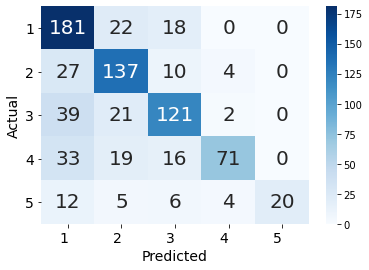

In [39]:
##1
print(accuracy_score(tests2[0], preds2[0]))
confusion = confusion_matrix(tests2[0], preds2[0])
confusion_matrix_df = pd.DataFrame(confusion, ('1', '2', '3', '4', '5'), ('1', '2', '3', '4', '5'))
heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={"size": 20}, fmt="d", cmap="Blues")
bottom, top = heatmap.get_ylim()
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize = 14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize = 14)
plt.ylabel('Actual', fontsize = 14)
plt.xlabel('Predicted', fontsize = 14)

0.6979166666666666


Text(0.5, 15.0, 'Predicted')

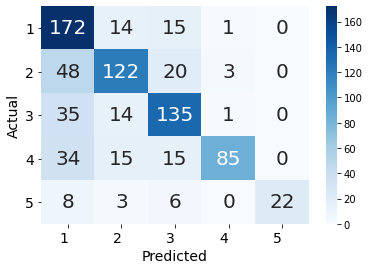

In [40]:
##2
print(accuracy_score(tests2[1], preds2[1]))
confusion = confusion_matrix(tests2[1], preds2[1])
confusion_matrix_df = pd.DataFrame(confusion, ('1', '2', '3', '4', '5'), ('1', '2', '3', '4', '5'))
heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={"size": 20}, fmt="d", cmap="Blues")
bottom, top = heatmap.get_ylim()
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize = 14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize = 14)
plt.ylabel('Actual', fontsize = 14)
plt.xlabel('Predicted', fontsize = 14)

0.6614583333333334


Text(0.5, 15.0, 'Predicted')

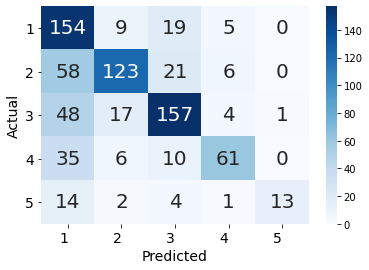

In [41]:
##3
print(accuracy_score(tests2[2], preds2[2]))
confusion = confusion_matrix(tests2[2], preds2[2])
confusion_matrix_df = pd.DataFrame(confusion, ('1', '2', '3', '4', '5'), ('1', '2', '3', '4', '5'))
heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={"size": 20}, fmt="d", cmap="Blues")
bottom, top = heatmap.get_ylim()
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize = 14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize = 14)
plt.ylabel('Actual', fontsize = 14)
plt.xlabel('Predicted', fontsize = 14)

0.6966145833333334


Text(0.5, 15.0, 'Predicted')

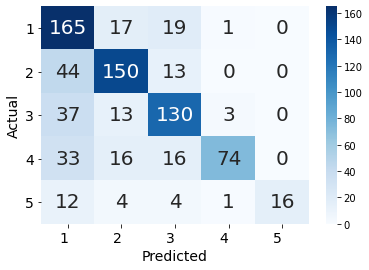

In [42]:
##4
print(accuracy_score(tests2[3], preds2[3]))
confusion = confusion_matrix(tests2[3], preds2[3])
confusion_matrix_df = pd.DataFrame(confusion, ('1', '2', '3', '4', '5'), ('1', '2', '3', '4', '5'))
heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={"size": 20}, fmt="d", cmap="Blues")
bottom, top = heatmap.get_ylim()
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize = 14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize = 14)
plt.ylabel('Actual', fontsize = 14)
plt.xlabel('Predicted', fontsize = 14)

0.681877444589309


Text(0.5, 15.0, 'Predicted')

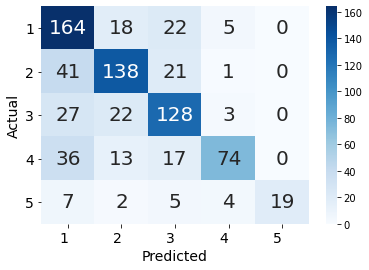

In [43]:
##5
print(accuracy_score(tests2[4], preds2[4]))
confusion = confusion_matrix(tests2[4], preds2[4])
confusion_matrix_df = pd.DataFrame(confusion, ('1', '2', '3', '4', '5'), ('1', '2', '3', '4', '5'))
heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={"size": 20}, fmt="d", cmap="Blues")
bottom, top = heatmap.get_ylim()
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize = 14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize = 14)
plt.ylabel('Actual', fontsize = 14)
plt.xlabel('Predicted', fontsize = 14)